In [1]:
import math
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pickle
import os
import mlflow
import mlflow.pytorch
import re
import logging
import spacy

from spacy.lang.en import English

import mlflow
from mlflow import log_metric, log_param, log_params, log_metrics

In [2]:
logging.basicConfig(filename='POSTransformer.log',level=logging.WARNING)

In [3]:
"""
datasets = os.listdir(".data/wikitext-2/wikitext-2/")

if "wiki.train.tokens" in datasets:
    print("Removing useless symbols from datasets...")
    pattern = r"[^\w'\.,;:\!\?]"
  #  pattern = r"[^\w']"
    for x in datasets:
        with open(f".data/wikitext-2/wikitext-2/{x}", "r") as _f:
            _f = _f.read()

        _f = re.sub(pattern, ' ', _f)

        with open(f".data/wikitext-2/wikitext-2/{x}", "w") as _w:
            _w = _w.write(_f)
    print("Cleaning finished")
_f = 0
"""

<>:18: DeprecationWarning: invalid escape sequence \w
<>:18: DeprecationWarning: invalid escape sequence \w
<>:18: DeprecationWarning: invalid escape sequence \w
<ipython-input-3-7ab039edd683>:18: DeprecationWarning: invalid escape sequence \w
  """


'\ndatasets = os.listdir(".data/wikitext-2/wikitext-2/")\n\nif "wiki.train.tokens" in datasets:\n    print("Removing useless symbols from datasets...")\n    pattern = r"[^\\w\'\\.,;:\\!\\?]"\n  #  pattern = r"[^\\w\']"\n    for x in datasets:\n        with open(f".data/wikitext-2/wikitext-2/{x}", "r") as _f:\n            _f = _f.read()\n\n        _f = re.sub(pattern, \' \', _f)\n\n        with open(f".data/wikitext-2/wikitext-2/{x}", "w") as _w:\n            _w = _w.write(_f)\n    print("Cleaning finished")\n_f = 0\n'

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
params = {"lr":1.8,"epochs":50,"embed_dim":240,"heads":8,"layers":2,"seq_len":32,"batch_size":64, "name":"POS2"}

mlflow.set_tracking_uri('http://beefyserv.local:8000/')
mlflow.set_experiment(params["name"]+"-layers"+str(params["layers"])+"-heads"+str(params["heads"]))
log_params(params)

In [6]:
def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to("cuda")
        return mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        x = self.dropout(x)
        x = x.to("cuda")
        return x

In [7]:
class TransformerModel(nn.Module):
    """
    
    """
    def __init__(self, d_model, nhead=2, num_encoder_layers=1, ntokens=5000, output=50):
        super(TransformerModel, self).__init__()
        
        self.output = output
        self.num_encoder_layers = num_encoder_layers
        self.nhead = nhead
        self.d_model = d_model
        self.ntokens = ntokens
        self.emb = nn.Embedding(self.ntokens, self.d_model)
        self.posenc = PositionalEncoding(d_model, 0.5)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=1024)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.linear = nn.Linear(self.d_model, self.output)
        self.trans_activation = None
        
    def save_activations(self, epoch=0, batch=0):
        """
        epoch: The running epoch, this information will be added to the files' names.
        batch: The running batch, this information will be added to the files' names
        
        """
        try:
            
            for x in range(len(self.transformer.layers)):
                # save the activations of each transformer encoder layer.
                with open(f"/PATH/{params['name']}-attention-{x}-{epoch}-{batch}.p", "wb") as _f:
                    pickle.dump(self.transformer.layers[x].attn_activation.cpu().detach().numpy(), _f)
                           
        except:
            logging.warning(f"Model: {params['name']} Failed to save activations for batch {batch} in epoch {epoch}! No More space left on disk!")
        return 0
        
    
    def forward(self, x, tgt, epoch=0, batch=0, flag="training"):
        x = self.emb(x) #* math.sqrt(self.d_model)
        tgt = self.emb(tgt)
        x = self.posenc(x)
        x = self.transformer(x, generate_square_subsequent_mask(x.shape[0]))
        self.trans_activation = x
        if not self.training and flag == "test":
            self.save_activations(epoch=epoch, batch=batch)
        return self.linear(x)


In [8]:
import torchtext
from torchtext.data.utils import get_tokenizer

TEXT = torchtext.data.Field(tokenize = "spacy", tokenizer_language="en", 
                            init_token=None, 
                            eos_token=None, 
                            stop_words = ["=", "==", "@", "@@", "<", ">", "@-@", "@,@","@.@","@_@", "<eos>", "<sos>", "<pad>"], 
                            lower=True)

train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data

batch_size = params["batch_size"]
eval_batch_size = params["batch_size"]
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

log_params({'val_data':val_data.shape, 
            'train_data.shape':train_data.shape, 
            'test_data.shape':test_data.shape, 
            'batch_size':batch_size, 'eval_batch_size':eval_batch_size})

In [9]:
"""
tags = [0]*len(train_txt.examples[0].text)

from tqdm import tqdm

for x in tqdm(range(len(train_txt.examples[0].text))):
    tags[x] = nlp(train_txt.examples[0].text[x])
"""

'\ntags = [0]*len(train_txt.examples[0].text)\n\nfrom tqdm import tqdm\n\nfor x in tqdm(range(len(train_txt.examples[0].text))):\n    tags[x] = nlp(train_txt.examples[0].text[x])\n'

In [10]:
"""
finaltags = [0]*len(train_txt.examples[0].text)
print(len(tags), len(finaltags))

for x in tqdm(range(len(tags))):
    for y in tags[x]:
        finaltags[x] = y.tag_

print(finaltags[:50])
"""

'\nfinaltags = [0]*len(train_txt.examples[0].text)\nprint(len(tags), len(finaltags))\n\nfor x in tqdm(range(len(tags))):\n    for y in tags[x]:\n        finaltags[x] = y.tag_\n\nprint(finaltags[:50])\n'

In [11]:
"""
print(len(finaltags))
import pickle
with open('wikitext.traintags.pickle', 'wb') as handle:
    pickle.dump(finaltags, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

"\nprint(len(finaltags))\nimport pickle\nwith open('wikitext.traintags.pickle', 'wb') as handle:\n    pickle.dump(finaltags, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [12]:
with open("wikitext.traintags.pickle", "rb") as h:
    traintags = pickle.load(h)
    
with open("wikitext.validtags.pickle", "rb") as h:
    valtags = pickle.load(h)
    
with open("wikitext.testtags.pickle", "rb") as h:
    testtags = pickle.load(h)

In [13]:
counter = 0
itotags = {}
tagstoi = {}
for x in nlp.get_pipe("tagger").labels:
    itotags[counter] = x
    tagstoi[x] = counter
    counter += 1
ntags = len(tagstoi.keys())

In [14]:
traintags = torch.Tensor([tagstoi[x] for x in traintags])
valtags = torch.Tensor([tagstoi[x] for x in valtags])
testtags = torch.Tensor([tagstoi[x] for x in testtags])

print(traintags.shape, valtags.shape)
train_data.shape

torch.Size([2056362]) torch.Size([214626])


torch.Size([32130, 64])

In [15]:
bptt = params["seq_len"]

def totags(vec):
    tagvec = [nlp(TEXT.vocab.itos[x.detach().data]) for x in vec]
    tagvec = [y.tag_ for x in tagvec for y in x]
    tagvec = [tagstoi[x] for x in tagvec]
    assert len(tagvec) == len(vec)
    return tagvec

def get_tags_batch(source, i, flag="other"):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    if model.training or flag == "train":
        target = trainingtags[i:i+seq_len].view(-1).long()
    elif flag == "test":
        target = testtags[i:i+seq_len].view(-1).long()
    else:
        target = validationtags[i:i+seq_len].view(-1).long()
    return data, target

In [16]:
def batchify_tags(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data

trainingtags = batchify_tags(traintags, params["batch_size"])
validationtags = batchify_tags(valtags, params["batch_size"])
testtags = batchify_tags(testtags, params["batch_size"])
log_params({"training-tags":trainingtags.shape, 
            "validation-tags":validationtags.shape, 
            "test-tags":testtags.shape})

In [17]:
ntokens = len(TEXT.vocab.stoi)
print(trainingtags.shape, train_data.shape)
print(validationtags.shape, val_data.shape)
print(testtags.shape, test_data.shape)


assert trainingtags.shape == train_data.shape
assert validationtags.shape == val_data.shape
assert testtags.shape == test_data.shape

print(len(train_data))

torch.Size([32130, 64]) torch.Size([32130, 64])
torch.Size([3353, 64]) torch.Size([3353, 64])
torch.Size([3785, 64]) torch.Size([3785, 64])
32130


In [18]:
model = TransformerModel(d_model=params["embed_dim"], nhead=params["heads"], num_encoder_layers=params["layers"], ntokens=ntokens, output=ntags)
model = model.to("cuda")
model

TransformerModel(
  (emb): Embedding(73024, 240)
  (posenc): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=

In [19]:
criterion = nn.CrossEntropyLoss()
lr = params["lr"]
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2.0, gamma=0.65)

In [20]:
import time
def train():
    model.train()
    total_loss = 0.
    cur_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_tags_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data.to(device), data.to(device), batch=batch, epoch=epoch)
        loss = criterion(output.view(-1, ntags), targets.to(device))
        total_loss += loss.item()

        acc = targets.to(device).eq(torch.argmax(output.view(-1, ntags), dim=1)).sum().detach().cpu().numpy()
        acc = acc / targets.shape[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        log_interval = params["batch_size"]
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            log_metrics({"train_loss":cur_loss, "train_accuracy":acc})
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.4f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | acc {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, acc))
            total_loss = 0
            start_time = time.time()
    

def evaluate(eval_model, data_source, flag):
    eval_model.eval() 
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    acc = 0
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_tags_batch(data_source, i, flag)
            output = eval_model(data.to(device), data.to(device),batch=i, epoch=epoch, flag=flag)
            acc = targets.to(device).eq(torch.argmax(output.view(-1, ntags), dim=1)).sum().detach().cpu().numpy()
            acc = acc / targets.shape[0]
            output_flat = output.view(-1, ntags)
            loss = criterion(output_flat, targets.to(device))
            total_loss += params["batch_size"] * loss.item()
    return total_loss / (len(data_source) - 1), acc

In [21]:
best_val_loss = float("inf")
epochs = params["epochs"] # The number of epochs
best_model = None

print("STARTING:::::::.........")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    train_loss, train_acc = evaluate(model, train_data, "train")
    log_metrics({"train_epoch_loss":train_loss, "train_epoch_accuracy":train_acc})
    
    val_loss, acc = evaluate(model, val_data, "other")
    log_metrics({"validation_loss":val_loss, "validation_accuracy":acc})
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid acc {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, acc))
    print('-' * 89)

    _1, _2 = evaluate(model, val_data, "test")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

STARTING:::::::.........
| epoch   1 |    64/ 1004 batches | lr 1.8000 | ms/batch 89.38 | loss  2.12 | acc     0.54
| epoch   1 |   128/ 1004 batches | lr 1.8000 | ms/batch 85.71 | loss  1.46 | acc     0.61
| epoch   1 |   192/ 1004 batches | lr 1.8000 | ms/batch 101.73 | loss  1.24 | acc     0.64
| epoch   1 |   256/ 1004 batches | lr 1.8000 | ms/batch 85.44 | loss  1.12 | acc     0.63
| epoch   1 |   320/ 1004 batches | lr 1.8000 | ms/batch 84.81 | loss  1.03 | acc     0.64
| epoch   1 |   384/ 1004 batches | lr 1.8000 | ms/batch 82.99 | loss  0.95 | acc     0.71
| epoch   1 |   448/ 1004 batches | lr 1.8000 | ms/batch 83.77 | loss  0.88 | acc     0.72
| epoch   1 |   512/ 1004 batches | lr 1.8000 | ms/batch 83.50 | loss  0.82 | acc     0.74
| epoch   1 |   576/ 1004 batches | lr 1.8000 | ms/batch 83.89 | loss  0.77 | acc     0.72
| epoch   1 |   640/ 1004 batches | lr 1.8000 | ms/batch 84.54 | loss  0.73 | acc     0.75
| epoch   1 |   704/ 1004 batches | lr 1.8000 | ms/batch 88.98 |

| epoch   6 |   128/ 1004 batches | lr 0.7605 | ms/batch 80.97 | loss  0.33 | acc     0.89
| epoch   6 |   192/ 1004 batches | lr 0.7605 | ms/batch 80.78 | loss  0.32 | acc     0.90
| epoch   6 |   256/ 1004 batches | lr 0.7605 | ms/batch 80.76 | loss  0.32 | acc     0.89
| epoch   6 |   320/ 1004 batches | lr 0.7605 | ms/batch 80.65 | loss  0.33 | acc     0.90
| epoch   6 |   384/ 1004 batches | lr 0.7605 | ms/batch 80.76 | loss  0.32 | acc     0.90
| epoch   6 |   448/ 1004 batches | lr 0.7605 | ms/batch 80.79 | loss  0.32 | acc     0.90
| epoch   6 |   512/ 1004 batches | lr 0.7605 | ms/batch 80.76 | loss  0.31 | acc     0.91
| epoch   6 |   576/ 1004 batches | lr 0.7605 | ms/batch 80.89 | loss  0.32 | acc     0.91
| epoch   6 |   640/ 1004 batches | lr 0.7605 | ms/batch 80.78 | loss  0.31 | acc     0.89
| epoch   6 |   704/ 1004 batches | lr 0.7605 | ms/batch 80.90 | loss  0.32 | acc     0.90
| epoch   6 |   768/ 1004 batches | lr 0.7605 | ms/batch 80.90 | loss  0.31 | acc     0.90

| epoch  11 |   256/ 1004 batches | lr 0.2089 | ms/batch 82.20 | loss  0.28 | acc     0.93
| epoch  11 |   320/ 1004 batches | lr 0.2089 | ms/batch 82.21 | loss  0.29 | acc     0.91
| epoch  11 |   384/ 1004 batches | lr 0.2089 | ms/batch 82.20 | loss  0.28 | acc     0.91
| epoch  11 |   448/ 1004 batches | lr 0.2089 | ms/batch 82.33 | loss  0.27 | acc     0.91
| epoch  11 |   512/ 1004 batches | lr 0.2089 | ms/batch 82.46 | loss  0.27 | acc     0.93
| epoch  11 |   576/ 1004 batches | lr 0.2089 | ms/batch 82.07 | loss  0.27 | acc     0.92
| epoch  11 |   640/ 1004 batches | lr 0.2089 | ms/batch 82.21 | loss  0.27 | acc     0.92
| epoch  11 |   704/ 1004 batches | lr 0.2089 | ms/batch 82.21 | loss  0.28 | acc     0.92
| epoch  11 |   768/ 1004 batches | lr 0.2089 | ms/batch 82.08 | loss  0.27 | acc     0.92
| epoch  11 |   832/ 1004 batches | lr 0.2089 | ms/batch 85.85 | loss  0.27 | acc     0.92
| epoch  11 |   896/ 1004 batches | lr 0.2089 | ms/batch 82.06 | loss  0.27 | acc     0.91

| epoch  16 |   384/ 1004 batches | lr 0.0882 | ms/batch 81.04 | loss  0.26 | acc     0.92
| epoch  16 |   448/ 1004 batches | lr 0.0882 | ms/batch 81.29 | loss  0.26 | acc     0.91
| epoch  16 |   512/ 1004 batches | lr 0.0882 | ms/batch 81.03 | loss  0.26 | acc     0.92
| epoch  16 |   576/ 1004 batches | lr 0.0882 | ms/batch 81.04 | loss  0.26 | acc     0.93
| epoch  16 |   640/ 1004 batches | lr 0.0882 | ms/batch 81.42 | loss  0.26 | acc     0.92
| epoch  16 |   704/ 1004 batches | lr 0.0882 | ms/batch 81.81 | loss  0.26 | acc     0.93
| epoch  16 |   768/ 1004 batches | lr 0.0882 | ms/batch 81.68 | loss  0.26 | acc     0.92
| epoch  16 |   832/ 1004 batches | lr 0.0882 | ms/batch 81.81 | loss  0.26 | acc     0.93
| epoch  16 |   896/ 1004 batches | lr 0.0882 | ms/batch 82.21 | loss  0.26 | acc     0.91
| epoch  16 |   960/ 1004 batches | lr 0.0882 | ms/batch 85.73 | loss  0.27 | acc     0.91
-----------------------------------------------------------------------------------------


| epoch  21 |   512/ 1004 batches | lr 0.0242 | ms/batch 83.01 | loss  0.26 | acc     0.93
| epoch  21 |   576/ 1004 batches | lr 0.0242 | ms/batch 83.22 | loss  0.26 | acc     0.93
| epoch  21 |   640/ 1004 batches | lr 0.0242 | ms/batch 83.25 | loss  0.26 | acc     0.91
| epoch  21 |   704/ 1004 batches | lr 0.0242 | ms/batch 83.37 | loss  0.26 | acc     0.92
| epoch  21 |   768/ 1004 batches | lr 0.0242 | ms/batch 83.24 | loss  0.26 | acc     0.93
| epoch  21 |   832/ 1004 batches | lr 0.0242 | ms/batch 83.38 | loss  0.26 | acc     0.92
| epoch  21 |   896/ 1004 batches | lr 0.0242 | ms/batch 83.38 | loss  0.25 | acc     0.91
| epoch  21 |   960/ 1004 batches | lr 0.0242 | ms/batch 83.23 | loss  0.27 | acc     0.92
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 108.07s | valid loss  0.29 | valid acc     0.95
-----------------------------------------------------------------------------------------
| epoch  22 |    

| epoch  26 |   640/ 1004 batches | lr 0.0102 | ms/batch 82.07 | loss  0.26 | acc     0.92
| epoch  26 |   704/ 1004 batches | lr 0.0102 | ms/batch 82.52 | loss  0.26 | acc     0.93
| epoch  26 |   768/ 1004 batches | lr 0.0102 | ms/batch 82.15 | loss  0.25 | acc     0.93
| epoch  26 |   832/ 1004 batches | lr 0.0102 | ms/batch 82.07 | loss  0.26 | acc     0.93
| epoch  26 |   896/ 1004 batches | lr 0.0102 | ms/batch 82.46 | loss  0.25 | acc     0.92
| epoch  26 |   960/ 1004 batches | lr 0.0102 | ms/batch 86.11 | loss  0.27 | acc     0.91
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 106.41s | valid loss  0.29 | valid acc     0.95
-----------------------------------------------------------------------------------------
| epoch  27 |    64/ 1004 batches | lr 0.0067 | ms/batch 87.22 | loss  0.27 | acc     0.92
| epoch  27 |   128/ 1004 batches | lr 0.0067 | ms/batch 85.45 | loss  0.26 | acc     0.92
| epoch  27 |   1

| epoch  31 |   768/ 1004 batches | lr 0.0028 | ms/batch 83.38 | loss  0.26 | acc     0.93
| epoch  31 |   832/ 1004 batches | lr 0.0028 | ms/batch 83.37 | loss  0.26 | acc     0.92
| epoch  31 |   896/ 1004 batches | lr 0.0028 | ms/batch 83.76 | loss  0.25 | acc     0.92
| epoch  31 |   960/ 1004 batches | lr 0.0028 | ms/batch 83.25 | loss  0.27 | acc     0.92
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 108.11s | valid loss  0.29 | valid acc     0.95
-----------------------------------------------------------------------------------------
| epoch  32 |    64/ 1004 batches | lr 0.0028 | ms/batch 82.06 | loss  0.27 | acc     0.92
| epoch  32 |   128/ 1004 batches | lr 0.0028 | ms/batch 80.77 | loss  0.26 | acc     0.91
| epoch  32 |   192/ 1004 batches | lr 0.0028 | ms/batch 80.91 | loss  0.26 | acc     0.92
| epoch  32 |   256/ 1004 batches | lr 0.0028 | ms/batch 80.90 | loss  0.26 | acc     0.92
| epoch  32 |   3

| epoch  36 |   896/ 1004 batches | lr 0.0012 | ms/batch 81.80 | loss  0.25 | acc     0.92
| epoch  36 |   960/ 1004 batches | lr 0.0012 | ms/batch 86.50 | loss  0.27 | acc     0.92
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 106.20s | valid loss  0.29 | valid acc     0.95
-----------------------------------------------------------------------------------------
| epoch  37 |    64/ 1004 batches | lr 0.0008 | ms/batch 85.72 | loss  0.27 | acc     0.92
| epoch  37 |   128/ 1004 batches | lr 0.0008 | ms/batch 84.25 | loss  0.26 | acc     0.91
| epoch  37 |   192/ 1004 batches | lr 0.0008 | ms/batch 84.30 | loss  0.26 | acc     0.92
| epoch  37 |   256/ 1004 batches | lr 0.0008 | ms/batch 84.29 | loss  0.26 | acc     0.93
| epoch  37 |   320/ 1004 batches | lr 0.0008 | ms/batch 84.26 | loss  0.27 | acc     0.92
| epoch  37 |   384/ 1004 batches | lr 0.0008 | ms/batch 84.03 | loss  0.26 | acc     0.92
| epoch  37 |   4

-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 106.64s | valid loss  0.29 | valid acc     0.95
-----------------------------------------------------------------------------------------
| epoch  42 |    64/ 1004 batches | lr 0.0003 | ms/batch 89.65 | loss  0.27 | acc     0.92
| epoch  42 |   128/ 1004 batches | lr 0.0003 | ms/batch 83.13 | loss  0.26 | acc     0.92
| epoch  42 |   192/ 1004 batches | lr 0.0003 | ms/batch 83.11 | loss  0.26 | acc     0.92
| epoch  42 |   256/ 1004 batches | lr 0.0003 | ms/batch 83.11 | loss  0.26 | acc     0.93
| epoch  42 |   320/ 1004 batches | lr 0.0003 | ms/batch 82.99 | loss  0.27 | acc     0.92
| epoch  42 |   384/ 1004 batches | lr 0.0003 | ms/batch 83.32 | loss  0.26 | acc     0.93
| epoch  42 |   448/ 1004 batches | lr 0.0003 | ms/batch 87.61 | loss  0.26 | acc     0.92
| epoch  42 |   512/ 1004 batches | lr 0.0003 | ms/batch 83.22 | loss  0.25 | acc     0.94
| epoch  42 |   5

| epoch  47 |    64/ 1004 batches | lr 0.0001 | ms/batch 85.66 | loss  0.27 | acc     0.92
| epoch  47 |   128/ 1004 batches | lr 0.0001 | ms/batch 84.47 | loss  0.26 | acc     0.92
| epoch  47 |   192/ 1004 batches | lr 0.0001 | ms/batch 84.30 | loss  0.26 | acc     0.92
| epoch  47 |   256/ 1004 batches | lr 0.0001 | ms/batch 84.46 | loss  0.26 | acc     0.93
| epoch  47 |   320/ 1004 batches | lr 0.0001 | ms/batch 84.26 | loss  0.27 | acc     0.92
| epoch  47 |   384/ 1004 batches | lr 0.0001 | ms/batch 84.31 | loss  0.26 | acc     0.93
| epoch  47 |   448/ 1004 batches | lr 0.0001 | ms/batch 89.20 | loss  0.25 | acc     0.93
| epoch  47 |   512/ 1004 batches | lr 0.0001 | ms/batch 83.73 | loss  0.25 | acc     0.93
| epoch  47 |   576/ 1004 batches | lr 0.0001 | ms/batch 83.58 | loss  0.26 | acc     0.92
| epoch  47 |   640/ 1004 batches | lr 0.0001 | ms/batch 83.33 | loss  0.26 | acc     0.92
| epoch  47 |   704/ 1004 batches | lr 0.0001 | ms/batch 83.39 | loss  0.26 | acc     0.93

In [23]:
# Save model
torch.save(best_model.state_dict(), f"{params['name']}-POSTAGGER-heads{params['heads']}-layers{params['layers']}.pth")

In [22]:
test_loss, acc = evaluate(model, test_data, "test")
print('=' * 89)
print('| End of training | test loss {:5.2f} | test acc {:8.2f}'.format(
    test_loss, acc))
print('=' * 89)
log_metrics({"test_loss":test_loss, "test_accuracy":acc})

| End of training | test loss  0.32 | test acc     0.93


In [48]:
print(model.transformer.layers[0].attn.shape)
print(model.transformer.layers[0].attn_preactivation.shape)
print(model.transformer.layers[0].attn_activation.shape)
print(model.transformer.layers[0].linear1.__dict__)

torch.Size([8, 8, 8])
torch.Size([8, 1, 240])
torch.Size([8, 1, 240])
{'training': False, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0246, -0.0959, -0.0409,  ..., -0.0102, -0.0462, -0.0010],
        [-0.0016,  0.0513,  0.1416,  ..., -0.0614,  0.1130, -0.0696],
        [ 0.0229,  0.0361, -0.0106,  ..., -0.0882, -0.1163, -0.1099],
        ...,
        [ 0.0035, -0.0778,  0.0333,  ...,  0.0304,  0.1031,  0.0032],
        [ 0.0056, -0.0431, -0.0162,  ..., -0.1074,  0.0186, -0.0449],
        [ 0.0466,  0.0509, -0.0273,  ..., -0.0752, -0.0119, -0.0439]],
       device='cuda:0', requires_grad=True)), ('bias', Parameter containing:
tensor([-0.2343, -0.0939, -0.0874,  ..., -0.1486, -0.0283, -0.0882],
       device='cuda:0', requires_grad=True))]), '_buffers': OrderedDict(), '_backward_hooks': OrderedDict(), '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules

In [27]:
frase = "Sil is a cute quirky girl".split()


def generate_sent(frase, model, TEXT, words=5):
    """
    This function gets a list of a split string and 
    returns a new string with the next N number of words 
    predicted by the model
    """

    frasevec = TEXT.numericalize([frase]).to("cuda")
    model.eval()
    var = model(frasevec, frasevec)
    most = torch.argmax(var.squeeze(1), dim=1).cpu().detach().data.numpy()
    most = [itotags[x] for x in most]
    print(len(frase), len(most))
    result = [f"{frase[x]} : {most[x]}" for x in range(len(most))]
    return result


f = generate_sent(frase, model, TEXT)
for x in f:
    print(x)
len(f)

6 6
Sil : NNP
is : VBZ
a : LS
cute : JJ
quirky : JJ
girl : NN


6

Plotting layer 1...
Plotting layer 2...


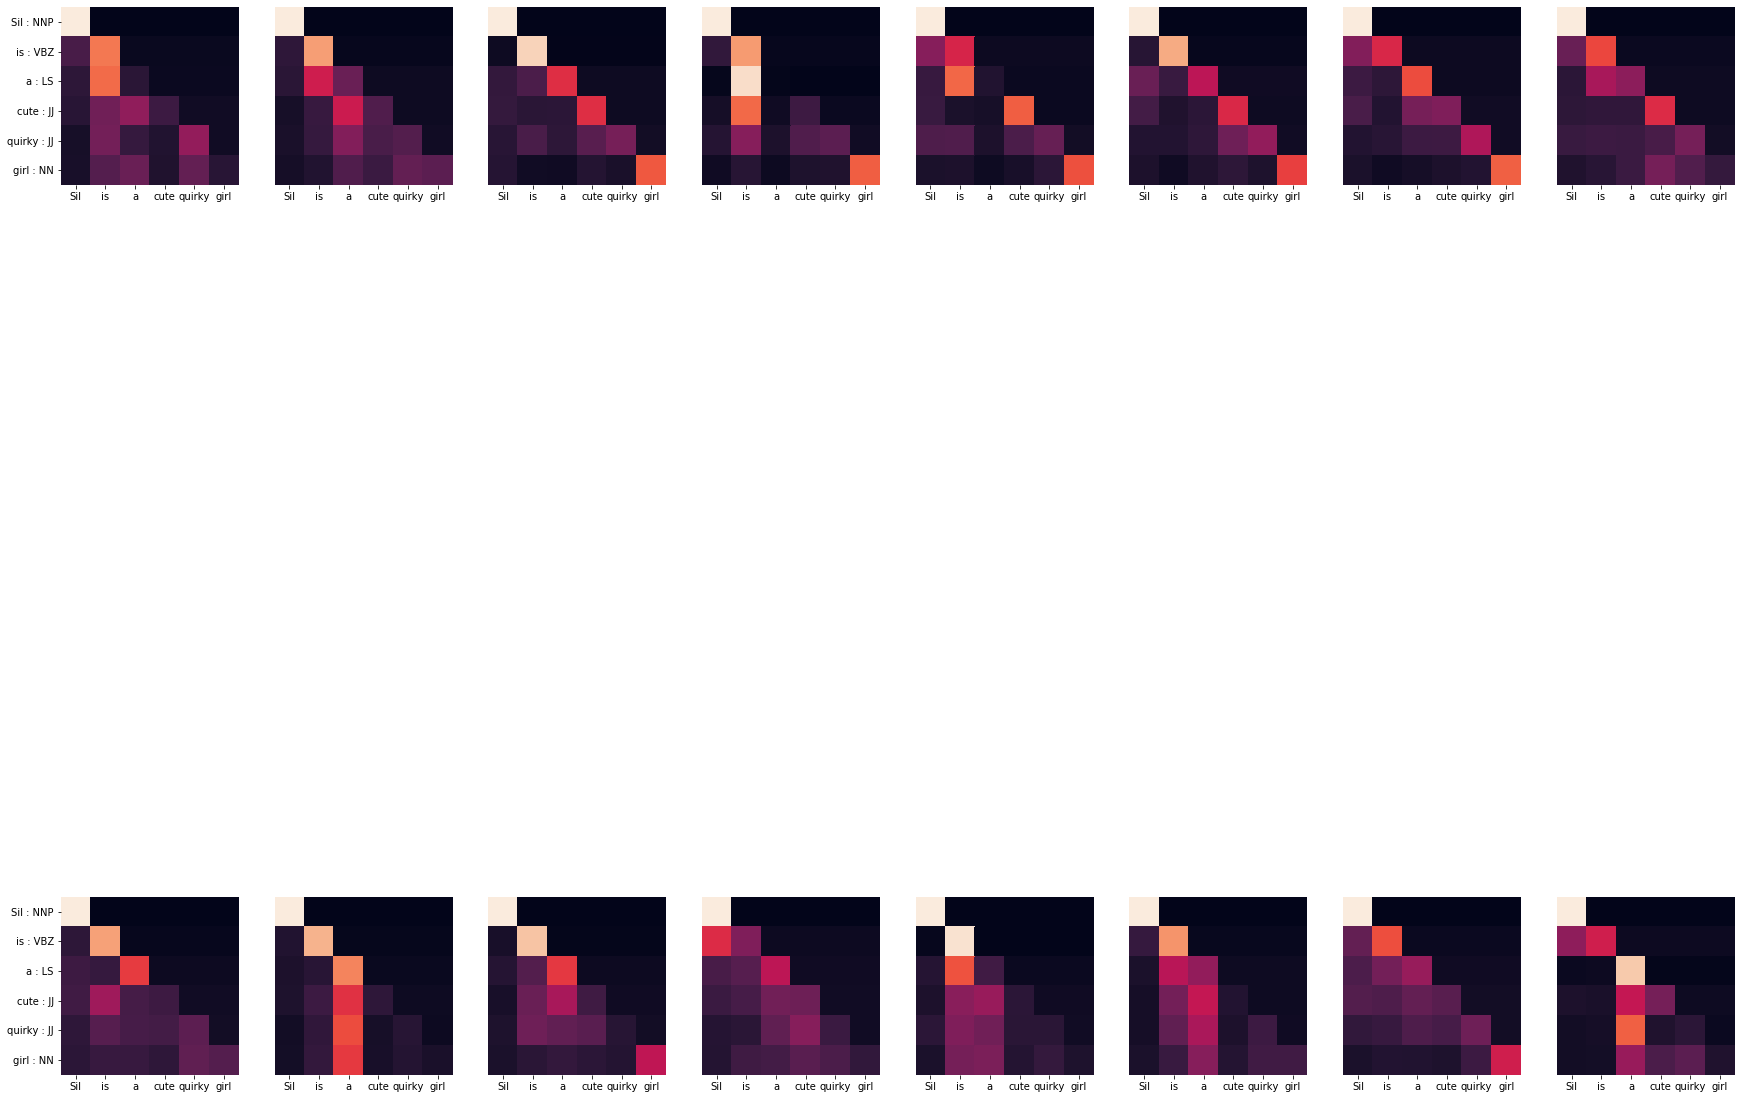

In [30]:
sent = frase

import seaborn
import matplotlib.pyplot as plt
import torch.nn.functional as F

fig, axs = plt.subplots(params["layers"],params["heads"], figsize=(30, 30))

for j in range(params["layers"]):
    
    print(f"Plotting layer {j+1}...")
    x = model.transformer.layers[j].attn.data
    x = F.softmax(x, dim = -1)
    
    for i in range(x.shape[0]):
        
        if i != 0:
            seaborn.heatmap(x[i,:,:].cpu().numpy(), square=True, cbar=False, 
                             cbar_kws={"shrink": .00001, "ticks":None, },
                             yticklabels=[""]*len(sent), xticklabels=sent, ax=axs[j,i])
            axs[j,i].tick_params(axis='y', which='both', length=0)
            
        else:
            seaborn.heatmap(x[i,:,:].cpu().numpy(), square=True, cbar=False, 
                             cbar_kws={"shrink": .00001, "ticks":None, },
                             yticklabels=f, xticklabels=sent, ax=axs[j,i])
